# Functional Connectivity
In the following, we will apply several functional connectivity metrics, mostly based on spectral measures (i.e. in frequency bands), such as coherence and phase-locking.

In [1]:
# This notebook is based on MNE-Python tutorials and examples, e.g.
# https://mne.tools/mne-connectivity/stable/auto_examples/cwt_sensor_connectivity.html
# https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_connectivity_spectrum.html
# https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_label_connectivity.html
# https://mne.tools/mne-connectivity/stable/auto_examples/mne_inverse_envelope_correlation.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5

In [2]:
import os.path as op
import numpy as np

import mne
from mne.datasets import sample

import mne_connectivity

print(__doc__)

Automatically created module for IPython interactive environment



## All-to-all connectivity in sensor space

Let's start by computing connectivity in sensor space, i.e. for pairs of sensors (without source estimation).

We know that this is strongly confounded by volume conduction and hard-to-impossible to interpret - but we have to start somewhere.

The following example computes the Phase Lag Index (PLI) between all gradiometers and shows the
connectivity in 3D using the helmet geometry. The left visual stimulation data
are used which produces strong connectvitiy in the right occipital sensors.


Set parameters and create epochs. We select one channel type at a time.



In [3]:
data_path = sample.data_path()
raw_fname = op.join(data_path, "MEG", "sample", "sample_audvis_filt-0-40_raw.fif")
event_fname = op.join(data_path, "MEG", "sample", "sample_audvis_filt-0-40_raw-eve.fif")

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.read_events(event_fname)

# Add a bad channel
raw.info["bads"] += ["MEG 2443"]

# choose only one channel type at a time (meg can be 'mag' or 'grad')
eeg, meg = True, False

# rejection thresholds depending on channel type used
if eeg:
    reject=dict(eeg=100e-6, eog=150e-6)
elif meg=='grad':
    reject=dict(grad=4000e-13, eog=150e-6)
elif meg=='mag':
    reject=dict(mag=4e-12, eog=150e-6)

# Pick MEG gradiometers
picks = mne.pick_types(
    raw.info, meg=meg, eeg=eeg, stim=False, eog=True, exclude="bads"
)

# Create epochs for the left visual condition
event_id = 1
tmin, tmax = -0.2, 1.5  # need a long enough epoch for 5 cycles
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=(None, 0),
    reject=reject
)

Opening raw data file /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated


We compute functional connectivity for a frequency band that contains the evoked response.

We exclude the baseline period since we don't expect systematic connectivity there.

In [4]:
fmin, fmax = 4.0, 9.0  # frequency band
tmin = 0.0  # exclude the baseline period
sfreq = raw.info["sfreq"]  # the sampling frequency

epochs.load_data().pick_types(meg=meg, eeg=eeg)  # just keep MEG and no EOG now
con = mne_connectivity.spectral_connectivity_epochs(
    epochs,
    method="pli",
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    tmin=tmin,
    mt_adaptive=False,
    n_jobs=1,
)

Loading data for 72 events and 256 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 006', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 003']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EEG : ['EEG 005', 'EEG 008']
    Rejecting  epoch based on EEG : ['EEG 00

Now we can visualize the connectivity in 3D:

In [5]:
data = con.get_data(output="dense")[:, :, 0]
mne_connectivity.viz.plot_sensors_connectivity(epochs.info, data, n_con=20)

Using pyvistaqt 3d backend.
True


__Exercises:__
* Look at different channels types.
* Look at different conditions.
* Look at different latency and frequency ranges.

**Question:** 
Can we trust this "connectivity" in sensor space? For example frontal-posterior connections for EEG?
Check the topographies for the evoked responses again.

## Functional Connectivity in source space

Let's start with coherence between a seed label and all other vertices. We need the usual ingredients for source estimation.

In [6]:
# We need our inverse operator and labels
fname_inv = data_path / "MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif"
label_name_lh = "Aud-lh"
fname_label_lh = data_path / f"MEG/sample/labels/{label_name_lh}.label"
subjects_dir = data_path / "subjects"

inverse_operator = mne.minimum_norm.read_inverse_operator(fname_inv)

Reading inverse operator decomposition from /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
 

Let's create the epochs again for all channel types combined.

In [7]:
raw = mne.io.read_raw_fif(raw_fname)
raw.info["bads"] += ["MEG 2443"]
picks = mne.pick_types(
    raw.info, meg=True, eeg=True, stim=False, eog=True, exclude="bads"
)
tmin, tmax = -0.2, 0.5

epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=(None, 0),
    reject=dict(mag=4e-12, grad=4000e-13, eog=150e-6),
)

Opening raw data file /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated


We will first apply source estimation to the evoked data in order to find the vertex with maximum power in auditory cortex, which we will then use as seed vertex for functional connectivity analysis.

In [8]:
method = 'dSPM'
snr = 3.0
lambda2 = 1.0 / snr**2
evoked = epochs.average()
stc = mne.minimum_norm.apply_inverse(evoked, inverse_operator, lambda2, method, pick_ori="normal")

# Read the label
label_lh = mne.read_label(fname_label_lh)

# Restrict the source estimate to the label in the left auditory cortex.
stc_label = stc.in_label(label_lh)

# Find number and index of vertex with most power.
src_pow = np.sum(stc_label.data**2, axis=1)  # sum over time
seed_vertno = stc_label.vertices[0][np.argmax(src_pow)]  # vertex with maximum power
seed_idx = np.searchsorted(stc.vertices[0], seed_vertno)  # index in orig stc

# Put seed index and target indices together for seed-based connectivity analysis.
n_sources = stc.data.shape[0]
indices = mne_connectivity.seed_target_indices([seed_idx], np.arange(n_sources))

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace 

Now we compute the source activation time courses for every vertex in every epoch.

Afterwards, we will use these to compute Coherence.

Note we use a lower SNR for single-trial analysis that for epoched data, and we need signed source activations.

In [9]:
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr**2

# Compute the inverse solution for each epoch. 
# We could use "return_generator=True" to return a generator object instead of a list.
# This allows us so to compute the coherence without having to keep all source estimates in memory.
# May not work with every method afterwards.
stcs = mne.minimum_norm.apply_inverse_epochs(
    epochs, inverse_operator, lambda2, method, pick_ori="normal"  # , return_generator=True
)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 72 (at most)
Processing epoch : 2 / 72 (at most)
Processing epoch : 3 / 72 (at most)
Processing epoch : 4 / 72 (at most)
Processing epoch : 5 / 72 (at most)
Processing epoch : 6 / 72 (at most)
Processing epoch : 7 / 72 (at most)
Processing epoch : 8 / 72 (at most)
Processing epoch : 9 / 72 (at most)
Processing epoch : 10 / 72 (at most)
    Rejecting  epoch based on EOG : ['EOG 061']
Processing epoch : 11 / 72 (at most)
Processing epoch : 12 / 72 (at most)
Processing epoch : 13 / 72 (at most)
    Rejecting  epoch based on

We can use the activation time courses to compute Coherence.

In [10]:
fmin = (8.0, 13.0)
fmax = (13.0, 30.0)
sfreq = raw.info["sfreq"]  # the sampling frequency

coh = mne_connectivity.spectral_connectivity_epochs(
    stcs,
    method="coh",
    mode="fourier",
    indices=indices,
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    n_jobs=1,
)
freqs = coh.freqs

Connectivity computation...
    computing connectivity for 7498 connections
    using t=-0.200s..0.499s for estimation (106 points)
    computing connectivity for the bands:
     band 1: 8.5Hz..12.7Hz (4 points)
     band 2: 14.2Hz..29.7Hz (12 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for e

We generate a SourceEstimate with the coherence. This is simple
since we used a single seed. For more than one seed we would have to choose
one of the slices within ``coh``.

Finally, we'll plot this source estimate on the brain.

In [11]:
# note we use frequency for the time axis in the SourceEstimate object - a bit of a hack.
tmin = np.mean(freqs[0])
tstep = np.mean(freqs[1]) - tmin
coh_stc = mne.SourceEstimate(
    coh.get_data(),
    vertices=stc.vertices,
    tmin=1e-3 * tmin,
    tstep=1e-3 * tstep,
    subject="sample",
)

# Now we can visualize the coherence using the plot method.
brain = coh_stc.plot(
    "sample",
    "inflated",
    "both",
    time_label="Coherence %0.1f Hz",
    subjects_dir=subjects_dir,
)
brain.show_view("lateral")
brain.add_label(label_lh, hemi='lh', borders=True, color='k')

Using control points [0.44370642 0.51549938 0.92978399]
True


The seed label is shown in the left hemisphere.

Note that connectivity for the two frequency bands is plotted as two "time points" (you may have to adjust the scaling).

**Exercise:**<br>
- Compare different connectivity methods, e.g. "coh" (classic Coherence) vs "imcoh" (Imaginary Part of Coherency). What happens, e.g. in terms of laterality? Why?

## Connectivity across frequencies for multiple labels

Connectivity computation...
Extracting time courses for 4 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 6 connections
    using t=0.000s..0.699s for estimation (106 points)
    frequencies: 8.5Hz..39.7Hz (23 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
Extracting time courses for 4 labels (mode: mean_flip)
    computing cross-spectral density for epoch 2
Extracting time courses for 4 labels (mode: mean_flip)
    computing cross-spectral density for epoch 3
Extracting time courses for 4 labels (mode: mean_flip)
    computing cross-spectral density for epoch 4
Extracting time courses for 4 labels (mode: mean_flip)
    computing cross-spectral density for epoch 5
Extracting time courses for 4 labels (mode: mean_flip)
    computing cross-spectral density for epoch 6
Extracting time courses for 4 labels (mode:

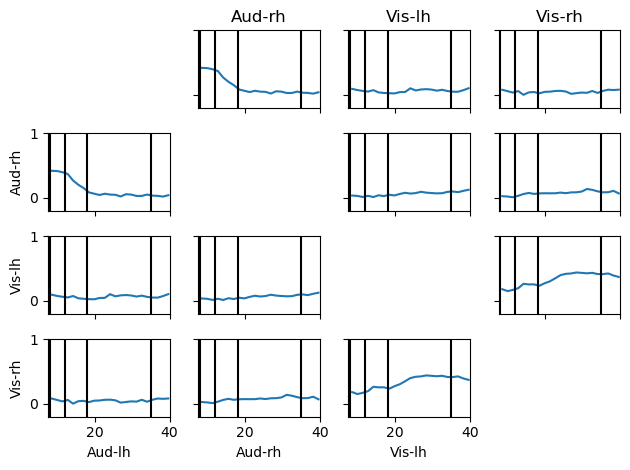

In [12]:
# Read some labels
names = ["Aud-lh", "Aud-rh", "Vis-lh", "Vis-rh"]
labels = [
    mne.read_label(data_path / f"MEG/sample/labels/{name}.label") for name in names
]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator["src"]
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode="mean_flip", return_generator=True
)

fmin, fmax = 7.5, 40.0  # frequency range for spectrum
sfreq = raw.info["sfreq"]  # the sampling frequency

con = mne_connectivity.spectral_connectivity_epochs(
    label_ts,
    method='coh',
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    mt_adaptive=True,
    n_jobs=1,
)
freqs = con.freqs

# Visualisation requires several subplots
from matplotlib import pyplot as plt
n_rows, n_cols = con.get_data(output="dense").shape[:2]
fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True)
for i in range(n_rows):
    for j in range(i + 1):
        if i == j:
            axes[i, j].set_axis_off()
            continue

        axes[i, j].plot(freqs, con.get_data(output="dense")[i, j, :])
        axes[j, i].plot(freqs, con.get_data(output="dense")[i, j, :])

        if j == 0:
            axes[i, j].set_ylabel(names[i])
            axes[0, i].set_title(names[i])
        if i == (n_rows - 1):
            axes[i, j].set_xlabel(names[j])
        axes[i, j].set(xlim=[fmin, fmax], ylim=[-0.2, 1])
        axes[j, i].set(xlim=[fmin, fmax], ylim=[-0.2, 1])

        # Show band limits
        for f in [8, 12, 18, 35]:
            axes[i, j].axvline(f, color="k")
            axes[j, i].axvline(f, color="k")
plt.tight_layout()
plt.show()

Coherence between auditory regions occurs ~<10Hz, probably reflecting the evoked response.

**Exercise**:<br> 
Is the increased coherence between left and right auditory regions due to leakage?

## All-to-all label connectivity
We can now be a bit bolder and compute connectivity among all pairs of labels in a parcellation.

In [13]:
# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot("sample", parc="aparc", subjects_dir=subjects_dir)
label_colors = [label.color for label in labels]

# We compute label time courses again, this time for all labels
src = inverse_operator["src"]
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode="mean_flip", return_generator=True
)

# Compute connectivity in one frequency band
fmin = 8.0
fmax = 13.0
sfreq = raw.info["sfreq"]  # the sampling frequency

method = 'coh'
con = mne_connectivity.spectral_connectivity_epochs(
    label_ts,
    method=method,
    mode="multitaper",
    sfreq=sfreq,
    fmin=fmin,
    fmax=fmax,
    faverage=True,
    mt_adaptive=True,
    n_jobs=1,
)

# con is a 3D array, get the connectivity for the first (and only) freq. band
con_res = con.get_data(output="dense")[:, :, 0]

Reading labels from parcellation...
   read 34 labels from /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/subjects/sample/label/lh.aparc.annot
   read 34 labels from /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/subjects/sample/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 68 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..0.699s for estimation (106 points)
    frequencies: 8.5Hz..12.7Hz (4 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
Extracting time courses for 68 labels (mode: mean_flip)
    computing cross-spectral density for epoch 2
Extracting time courses for 68 labels (mode: mean_flip)
    computing cross-spectral density for epoch 3
Extracting time courses for 68 la

Visualization is now a bit more tricky, but worth it...

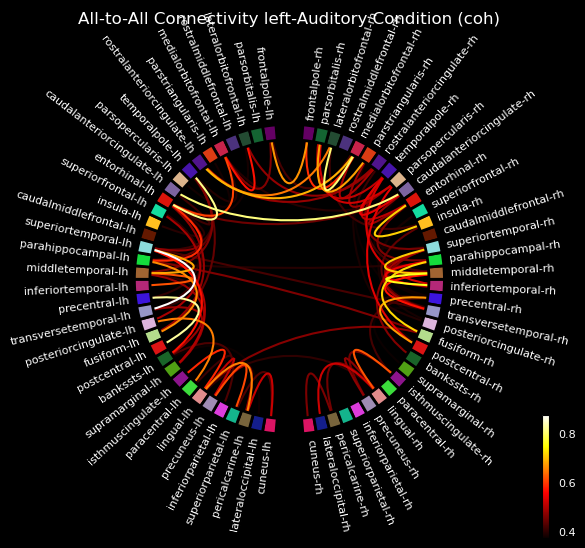

In [14]:
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith("lh")]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + "rh" for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = mne.viz.circular_layout(
    label_names, node_order, start_pos=90, group_boundaries=[0, len(label_names) / 2]
)

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
fig, ax = plt.subplots(figsize=(8, 8), facecolor="black", subplot_kw=dict(polar=True))
mne_connectivity.viz.plot_connectivity_circle(
    con_res,
    label_names,
    n_lines=100,
    node_angles=node_angles,
    node_colors=label_colors,
    title="All-to-All Connectivity left-Auditory " "Condition (%s)" % method,
    ax=ax,
)
fig.tight_layout()


**Exercise**:<br>
- Compare different methods, e.g. 'imcoh' vs 'coh', and 'plv' vs 'pli', i.e. methods that ignove vs don't ignore zero-lag connectivity due to leakage.

## Time-frequency analysis in source space

We can compute connectivity methods across frequency and time. This will increase the number of dimensions in the output, so we have to decide what to visualize.

In [15]:
# Read two labels for left and right auditory cortices
label_names = ["Aud-lh", "Aud-rh"]
meg_path = data_path / "MEG" / "sample"
fname_labels = [meg_path / "labels" / f"{ln}.label" for ln in label_names]
labels = [mne.read_label(fl) for fl in fname_labels]

In [16]:
# Read some labels
names = ["Aud-lh", "Aud-rh", "Vis-lh", "Vis-rh"]
labels = [
    mne.read_label(data_path / f"MEG/sample/labels/{name}.label") for name in names
]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator["src"]
label_ts = mne.extract_label_time_course(
    stcs, labels, src, mode="mean_flip", return_generator=False
)

method = 'coh'
cwt_freqs = np.arange(7, 45, 1)
con = mne_connectivity.spectral_connectivity_epochs(
    label_ts,
    method=method,
    mode="cwt_morlet",  # time-frequency option
    sfreq=sfreq,
    cwt_freqs=cwt_freqs,
    cwt_n_cycles=cwt_freqs/3.,
    faverage=False,
    n_jobs=1,
)

# get values for one pair or labels
# note it's from the lower triangle of the connectivity matrix
con_mats = con.get_data(output='dense')
con_mat = con_mats[3, 2, :, :]

Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting time courses for 4 labels (mode: mean_flip)
Extracting

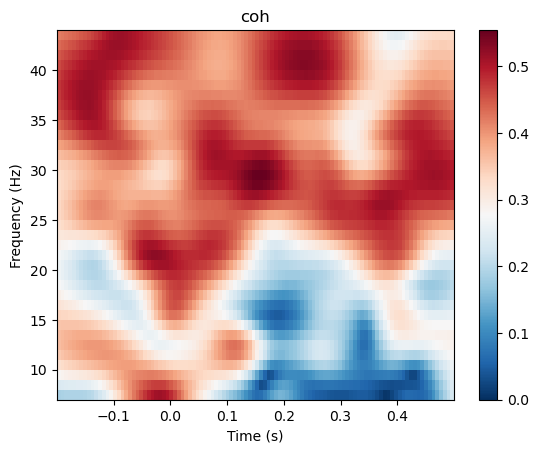

In [17]:
times = stcs[0].times
# View time-frequency plots
fig = plt.imshow(
    con_mat,
    extent=[times[0], times[-1], cwt_freqs[0], cwt_freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=0.0,
    vmax=con_mat.max(),
    cmap="RdBu_r",
)
plt.colorbar(fig)
fig.axes.set(xlabel="Time (s)", ylabel="Frequency (Hz)", title=method)
plt.show()

__Exercises__: 
* Check the dimensions of the output matrices.
* Change the (number of) labels, e.g. look at the two visual labels. If there any connectivity - why not?
* Are you interested in evoked versus induced power?

## Resting State Connectivity

We create epochs and prepare to band-pass filter them.

In [18]:
subject = 'sample'
duration = 10.0
events = mne.make_fixed_length_events(raw, duration=duration)
tmax = duration - 1.0 / raw.info["sfreq"]
epochs = mne.Epochs(
    raw, events=events, tmin=0, tmax=tmax, baseline=None, reject=reject
)
sfreq = epochs.info["sfreq"]


Not setting metadata
27 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
4 projection items activated


Reading labels from parcellation...
   read 75 labels from /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/subjects/sample/label/lh.aparc.a2009s.annot
   read 75 labels from /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/subjects/sample/label/rh.aparc.a2009s.annot
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 006', 'EEG 007']
Processing epoch : 1 / 27 (at most)
Extracting time courses for 150 labels (mode: mean_fl

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Using control points [80. 82. 86.]
True


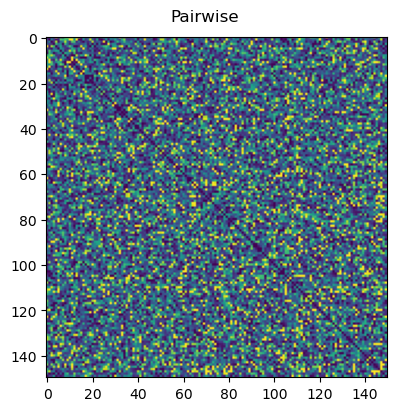

In [20]:

labels = mne.read_labels_from_annot(subject, "aparc.a2009s", subjects_dir=subjects_dir)
stcs = mne.minimum_norm.apply_inverse_epochs(
    epochs, inverse_operator, lambda2=1.0 / 9.0, pick_ori="normal", return_generator=True
)
label_ts = mne.extract_label_time_course(
    stcs, labels, inverse_operator["src"], return_generator=False
)
del stcs

freqs = (2,20)  # range for evoked response, quite broad
def bp_gen(label_ts):
    """Make a generator that band-passes on the fly."""
    for ts in label_ts:
        yield mne.filter.filter_data(ts, sfreq, freqs[0], freqs[1])


corr_obj = mne_connectivity.envelope_correlation(bp_gen(label_ts), orthogonalize='pairwise')
corr = corr_obj.combine()
corr = corr.get_data(output="dense")[:, :, 0]


def plot_corr(corr, title):
    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
    ax.imshow(corr, cmap="viridis", clim=np.percentile(corr, [5, 95]))
    fig.suptitle(title)


plot_corr(corr, "Pairwise")


def plot_degree(corr, title):
    threshold_prop = 0.5  # percentage of strongest edges to keep in the graph
    degree = mne_connectivity.degree(corr, threshold_prop=threshold_prop)
    stc = mne.labels_to_stc(labels, degree)
    stc = stc.in_label(
        mne.Label(inverse_operator["src"][0]["vertno"], hemi="lh")
        + mne.Label(inverse_operator["src"][1]["vertno"], hemi="rh")
    )
    return stc.plot(
        clim=dict(kind="percent", lims=[75, 85, 95]),
        colormap="gnuplot",
        subjects_dir=subjects_dir,
        views="dorsal",
        hemi="both",
        smoothing_steps=25,
        time_label=title,
    )


brain = plot_degree(corr, "Beta (pairwise, aparc_sub)")

__Exercises__: 
* Try different thresholds and frequency ranges. How reliable do you find the result?
* What happens to the results if we don't use pairwise orthogonalisation?